In [22]:
import serial
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import binascii

In [27]:
# Initialize serial connection
ser = serial.Serial('COM6', 57600, timeout=1)  # Adjust baud rate if needed

In [3]:
def read_serial():
    """Read a single command from the serial port."""
    # data = ser.read(18)  # Read 18 bytes (9 bytes repeated twice)
    data = ser.read_until(expected=b'\n', size=None)  # Read 
    return data.hex()

def analyze_movement(movement_name):
    """Collect and analyze data for a specific movement."""
    print(f"Analyzing {movement_name}")
    data = []
    
    while True:
        input("Move the control and press Enter to capture data (or 'q' to finish): ")
        if input().lower() == 'q':
            break
        
        command = read_serial()
        data.append(command)
        print(f"Captured: {command}")
    
    return pd.DataFrame(data, columns=['command'])


Analyzing Left Eyelid
Captured: fa000401400109c04afa000401400109c04a
Captured: fa000401400135ec76fa000401400135ec76
Analyzing Right Eyelid
Captured: fa0004014001a65ee7fa0004014001a65ee7fa000401200154ab75fa000401200154ab75
Captured: fa0004012001217842fa0004012001217842

Analyzing Left Eyelid:
Changing bytes:
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
34     True
35     True
dtype: bool

Byte 12:
12
0    1
3    1
Name: count, dtype: int64

Byte 13:
13
9    1
5    1
Name: count, dtype: int64

Byte 14:
14
c    1
e    1
Name: count, dtype: int64

Byte 15:
15
0    1
c    1
Name: count, dtype: int64

Byte 16:
16
4    1
7    1
Name: co

ValueError: invalid literal for int() with base 10: 'c'

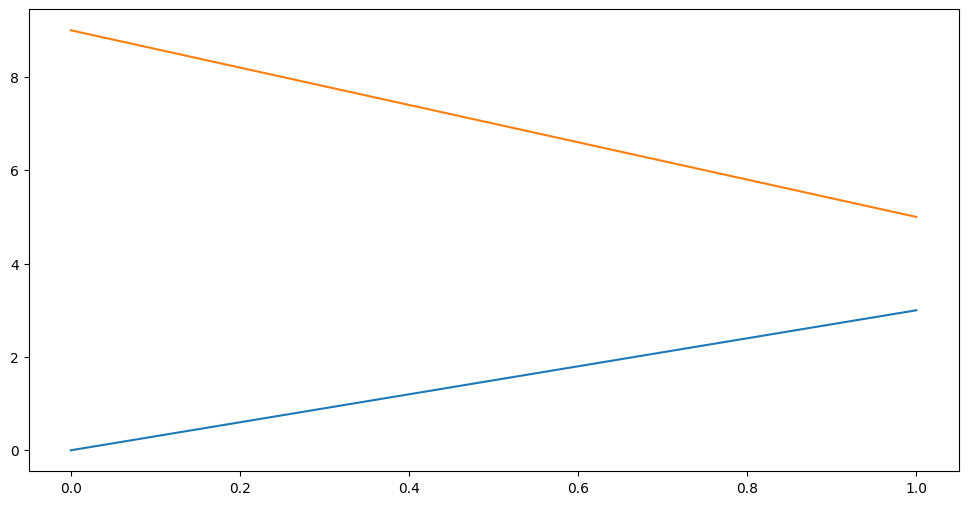

In [4]:

movements = [
    "Left Eyelid",
    "Right Eyelid",
    # "Eye Horizontal",
    # "Eye Vertical",
    # "Neck Vertical",
    # "Neck Horizontal",
    # "Head Tilt"
]

movement_data = {}

for movement in movements:
    movement_data[movement] = analyze_movement(movement)

# Close the serial connection
ser.close()

# Analyze the collected data
def analyze_command_structure(df):
    """Analyze the structure of the commands for a movement."""
    commands = df['command'].tolist()
    
    # Split each command into bytes
    byte_df = pd.DataFrame([list(cmd) for cmd in commands])
    
    # Analyze which bytes change
    changing_bytes = byte_df.apply(lambda x: len(set(x)) > 1)
    
    print("Changing bytes:")
    print(changing_bytes)
    
    # Analyze the range of changing bytes
    for col in byte_df.columns[changing_bytes]:
        print(f"\nByte {col}:")
        print(byte_df[col].value_counts())

# Analyze each movement
for movement, df in movement_data.items():
    print(f"\nAnalyzing {movement}:")
    analyze_command_structure(df)

# Visualize the data
def plot_movement_data(movement, df):
    """Plot the changing bytes for a movement."""
    commands = df['command'].tolist()
    byte_df = pd.DataFrame([list(cmd) for cmd in commands])
    
    changing_bytes = byte_df.columns[byte_df.apply(lambda x: len(set(x)) > 1)]
    
    plt.figure(figsize=(12, 6))
    for col in changing_bytes:
        plt.plot(byte_df[col].astype(int), label=f'Byte {col}')
    
    plt.title(f'{movement} - Changing Bytes')
    plt.xlabel('Command Index')
    plt.ylabel('Byte Value')
    plt.legend()
    plt.show()

# Plot data for each movement
for movement, df in movement_data.items():
    plot_movement_data(movement, df)

# Conclude the analysis
print("\nConclusion:")
print("Based on the analysis, we can infer the following about the command structure:")
print("1. The first two bytes (fa 00) seem to be a constant header.")
print("2. The third byte might be an identifier for the type of command or movement.")
print("3. The changing bytes likely represent the position or intensity of the movement.")
print("4. The last two bytes might be a checksum or end-of-command marker.")
print("\nFurther analysis and testing would be needed to confirm these hypotheses and determine the exact meaning of each byte.")

In [1]:
print("\033[41mRed background\033[0m \033[44mBlue background\033[0m \033[40mGreen background\033[0m")

Red background Blue background Green background


In [6]:
def compare_hex_strings(hex1, hex2):
    hex1_pairs = [hex1[i:i+2] for i in range(0, len(hex1), 2)]
    hex2_pairs = [hex2[i:i+2] for i in range(0, len(hex2), 2)]
    
    print(' '.join(hex1_pairs))
    
    colored_output = []
    for pair1, pair2 in zip(hex1_pairs, hex2_pairs):
        if pair1 == pair2:
            colored_output.append(f"\033[44m{pair2}\033[0m")
        else:
            colored_output.append(f"\033[41m{pair2}\033[0m")
    
    print(' '.join(colored_output))

# Example usage
compare_hex_strings("0001100ab0f", "0001100ab1f")


Red background Blue background Green background
00 01 10 0a b0 f
00 01 10 0a b1 f


In [13]:
import serial
import time

# ... existing code ...

def read_and_compare_serial_commands():
    """Read serial commands and print them in blue if they are the same as the previous message or red if different."""
    ser = serial.Serial('COM6', 57600, timeout=1)  # Adjust port and baud rate if needed
    previous_command = None

    try:
        while True:
            # Read 18 bytes
            command = ser.read(18).hex()

            if previous_command is None:
                # First command, print in blue
                print(f"\033[44m{' '.join([command[i:i+2] for i in range(0, len(command), 2)])}\033[0m")
            else:
                # Compare with previous command
                colored_output = []
                for i in range(0, len(command), 2):
                    pair = command[i:i+2]
                    if command[i:i+2] == previous_command[i:i+2]:
                        colored_output.append(f"\033[44m{pair}\033[0m")  # Blue for same
                    else:
                        colored_output.append(f"\033[41m{pair}\033[0m")  # Red for different
                
                print(' '.join(colored_output))

            previous_command = command
            time.sleep(0.1)  # Adjust delay as needed

    except KeyboardInterrupt:
        print("\nStopped reading serial commands.")
    finally:
        ser.close()

# Usage
if __name__ == "__main__":
    read_and_compare_serial_commands()


fa 00 04 01 40 01 b7 6f f8 fa 00 04 01 40 01 b7 6f f8

fa 00 04 01 40 01 f9 b1 3b fa 00 04 01 40 01 fc b4 3e
fa 00 04 01 40 01 fe b6 40 fa 00 04 01 40 01 ff b7 41
fa 00 04 01 40 01 ff b7 41 fa 00 04 01 20 01 f7 4f 19
fa 00 04 01 20 01 fa 52 1c fa 00 04 01 20 01 fe 56 20
fa 00 04 01 20 01 fd 55 1f fa 00 04 01 20 01 fd 55 1f


fa 00 04 01 10 01 dc 04 ed fa 00 04 01 10 01 e5 0d f6
fa 00 04 01 10 01 ed 15 fe fa 00 04 01 10 01 fa 22 0c
fa 00 04 01 10 01 ff 27 11 fa 00 04 01 10 01 ff 27 11
fa 00 04 01 10 01 ff 27 11 fa 00 04 01 20 01 fb 53 1d
fa 00 04 01 20 01 fb 53 1d fa 00 04 01 40 01 fc b4 3e
fa 00 04 01 40 01 fc b4 3e fa 00 04 01 20 01 e0 38 02
fa 00 04 01 20 01 f3 4b 15 fa 00 04 01 20 01 f8 50 1a
fa 00 04 01 20 01 f8 50 1a fa 00 04 01 10 01 f5 1d 07
fa 00 04 01 10 01 f8 20 0a fa 00 04 01 10 01 f8 20 0a












Stopped reading serial commands.


Another try

In [18]:
def process_command(command):
    # Add your command processing logic here
    # This function is called for each complete command received
    pass

def read_commands():
    buffer = bytearray()
    print("Listening for commands...")

    try:
        while True:
            byte = ser.read(1)
            if not byte:
                continue

            buffer.extend(byte)

            # Check if we have at least 2 bytes and they form a new header
            if len(buffer) >= 2 and buffer[-2:] == b'\xfa\x00':
                # If we already had a command in the buffer, print it
                if len(buffer) > 2:
                    command = buffer[:-2]  # Exclude the new header
                    hex_string = binascii.hexlify(command).decode('ascii')
                    print(f"Command: {hex_string}")
                    
                    # Process the command here if needed
                    process_command(command)
                    
                    # Clear the buffer, keeping only the new header
                    buffer = buffer[-2:]
            
            # Optional: Add a maximum buffer size check to prevent memory issues
            if len(buffer) > 1024:  # Adjust this value as needed
                print("Buffer overflow, clearing buffer")
                buffer.clear()

    except KeyboardInterrupt:
        print("\nProgram terminated by user")
    finally:
        print("Stopping command reading")

In [25]:
def process_command(command):
    # Add your command processing logic here
    # This function is called for each complete command received
    pass

def read_commands():
    buffer = bytearray()
    previous_command = None
    print("Listening for commands...")

    try:
        while True:
            byte = ser.read(1)
            if not byte:
                continue

            buffer.extend(byte)

            # Check if we have at least 2 bytes and they form a new header
            if len(buffer) >= 2 and buffer[-2:] == b'\xfa\x00':
                # If we already had a command in the buffer, print it
                if len(buffer) > 2:
                    command = buffer[:-2]  # Exclude the new header
                    hex_string = binascii.hexlify(command).decode('ascii')
                    
                    # Format and color the output
                    formatted_output = format_and_color_command(hex_string, previous_command)
                    print(f"Command: {formatted_output}")
                    
                    # Process the command here if needed
                    process_command(command)
                    
                    # Update previous_command
                    previous_command = hex_string
                    
                    # Clear the buffer, keeping only the new header
                    buffer = buffer[-2:]
            
            # Optional: Add a maximum buffer size check to prevent memory issues
            if len(buffer) > 1024:  # Adjust this value as needed
                print("Buffer overflow, clearing buffer")
                buffer.clear()

    except KeyboardInterrupt:
        print("\nProgram terminated by user")
    finally:
        print("Stopping command reading")

def format_and_color_command(hex_string, previous_command):
    hex_pairs = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
    
    if previous_command is None:
        # First command, print all in blue
        return ' '.join([f"\033[44m{pair}\033[0m" for pair in hex_pairs])
    
    prev_pairs = [previous_command[i:i+2] for i in range(0, len(previous_command), 2)]
    
    colored_output = []
    for pair, prev_pair in zip(hex_pairs, prev_pairs):
        if pair == prev_pair:
            colored_output.append(f"\033[44m{pair}\033[0m")  # Blue for same
        else:
            colored_output.append(f"\033[41m{pair}\033[0m")  # Red for different
    
    return ' '.join(colored_output)

In [ ]:
# Run this cell to start reading commands
# To stop, interrupt the kernel (usually a stop button in the Jupyter interface)
read_commands()

Listening for commands...
Command: fa 00 04 01 40 01 f8 b0 3a
Command: fa 00 04 01 40 01 fa b2 3c
Command: fa 00 04 01 40 01 fa b2 3c
Command: fa 00 04 01 40 01 ca 82 0c
Command: fa 00 04 01 40 01 c6 7e 08
Command: fa 00 04 01 40 01 b9 71 fa
Command: fa 00 04 01 40 01 b9 71 fa
Command: fa 00 04 01 40 01 4b 03 8c
Command: fa 00 04 01 40 01 4b 03 8c
Command: fa 00 04 01 40 01 07 be 48
Command: fa 00 04 01 40 01 07 be 48
Command: fa 00 04 01 40 01 59 11 9a
Command: fa 00 04 01 40 01 59 11 9a
Command: fa 00 04 01 40 01 82 3a c3
Command: fa 00 04 01 40 01 82 3a c3
Command: fa 00 04 01 40 01 ac 64 ed
Command: fa 00 04 01 40 01 ac 64 ed
Command: fa 00 04 01 20 01 a9 01 ca
Command: fa 00 04 01 20 01 a9 01 ca
Command: fa 00 04 01 10 01 a3 ca b4
Command: fa 00 04 01 10 01 a3 ca b4
Command: fa 00 04 01 08 01 a3 b2 ac
Command: fa 00 04 01 08 01 a3 b2 ac
Command: fa 00 04 01 04 01 a0 a3 a5
Command: fa 00 04 01 04 01 a0 a3 a5
Command: fa 00 04 01 08 01 9b aa a4
Command: fa 00 04 01 08 01 9b aa a4
Co